# Short-term Temperature Model Test

## Import dependencies and data

In [455]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [456]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [457]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [458]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
#     ('flow', 'FF01_GP101'),
#     ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

In [459]:
# RESAMPLE to MINUTE-FREQ

data = data.groupby(['month', 'day', 'hour', 'minute']).agg({
    ('flow', 'TA01_GP101'):'sum',
    ('temperatures', 'DC_GT101_GM101'):'mean',
    ('temperatures', 'DC_GT102_GM102'):'mean',
    ('temperatures', 'DC_GT103_GM103'):'mean',
    ('temperatures', 'DC_GT104_GM104'):'mean',
    ('temperatures', 'DC_GT401_GM401'):['sum', 'mean'],
    ('temperatures', 'DC_GT301_damped'):'mean',  # REMOVE?
    ('temperatures', 'DC_GT301_outdoor'):'mean', # REMOVE?
    ('setpoints', 'TA01_GT10X_GM10X'):'mean',
    ('sun', 'gsi'):'sum',
    ('sun', 'vol'):'sum',
    ('time', 'mod'):'mean',
    ('time', 'doy'):'mean'
})

## Describe Df

In [460]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID             
flow          TA01_GP101        sum     0
temperatures  DC_GT101_GM101    mean    4
              DC_GT102_GM102    mean    4
              DC_GT103_GM103    mean    4
              DC_GT104_GM104    mean    4
              DC_GT401_GM401    sum     0
                                mean    4
              DC_GT301_damped   mean    4
              DC_GT301_outdoor  mean    4
setpoints     TA01_GT10X_GM10X  mean    4
sun           gsi               sum     0
              vol               sum     0
time          mod               mean    0
              doy               mean    0
dtype: int64





In [461]:
# remove single NAN
data = data.dropna(how='any')

In [462]:
# describe cols
data.describe().transpose()

count         mean          std  \
category     sensor_ID                                                   
flow         TA01_GP101       sum   128166.0  4700.082495  1213.168093   
temperatures DC_GT101_GM101   mean  128166.0    17.493945    11.282786   
             DC_GT102_GM102   mean  128166.0    20.385034     1.247959   
             DC_GT103_GM103   mean  128166.0    20.963436     1.546697   
             DC_GT104_GM104   mean  128166.0    20.853181     1.618126   
             DC_GT401_GM401   sum   128166.0    98.906723     6.925642   
                              mean  128166.0    49.457833     3.447272   
             DC_GT301_damped  mean  128166.0    -5.075482     6.692264   
             DC_GT301_outdoor mean  128166.0    -5.044722     6.653557   
setpoints    TA01_GT10X_GM10X mean  128166.0    20.661871     0.752610   
sun          gsi              sum   128166.0    59.221537   147.700099   
             vol              sum   128166.0   682.192274  1918.688387   
time         mod              mean  128166.0     0.631388     0.306821   
             doy              mean  128166.0     0.316676     0.202928   

                                             min          25%          50%  \
category     sensor_ID                                                       
flow         TA01_GP101       sum   1.801300e+03  3718.800000  4116.500000   
temperatures DC_GT101_GM101   mean -1.990000e+01    19.650000    20.500000   
             DC_GT102_GM102   mean  1.240000e+01    19.600000    20.300000   
             DC_GT103_GM103   mean  1.045000e+01    20.000000    20.600000   
             DC_GT104_GM104   mean  1.085000e+01    19.800000    20.400000   
             DC_GT401_GM401   sum   3.100000e+01    97.500000   100.300000   
                              mean  1.550000e+01    48.750000    50.150000   
             DC_GT301_damped  mean -2.160000e+01   -10.400000    -3.800000   
             DC_GT301_outdoor mean -2.090000e+01   -10.300000    -3.700000   
setpoints    TA01_GT10X_GM10X mean  2.000000e+01    20.000000    20.000000   
sun          gsi              sum   0.000000e+00     0.000000     0.007659   
             vol              sum   0.000000e+00     0.000000     0.000000   
time         mod              mean  0.000000e+00     0.378649     0.697790   
             doy              mean  1.224647e-16     0.128748     0.296713   

                                            75%          max  
category     sensor_ID                                        
flow         TA01_GP101       sum   5476.800000  8369.400000  
temperatures DC_GT101_GM101   mean    21.450000    29.000000  
             DC_GT102_GM102   mean    21.000000    30.300000  
             DC_GT103_GM103   mean    21.700000    31.000000  
             DC_GT104_GM104   mean    21.600000    32.050000  
             DC_GT401_GM401   sum    102.500000   112.400000  
                              mean    51.250000    56.200000  
             DC_GT301_damped  mean     0.150000     9.300000  
             DC_GT301_outdoor mean     0.300000     8.400000  
setpoints    TA01_GT10X_GM10X mean    21.500000    22.100000  
sun          gsi              sum     20.698287   982.640000  
             vol              sum      0.511399  7200.000000  
time         mod              mean     0.917060     1.000000  
             doy              mean     0.501242     0.668064

## Process / transform variables 

In [463]:
# # remove erroneous setpoints data
# data = data[data.setpoints.TA01_GT10X_GM10X != 0.0]

# # # set temp to adjusted for setpoint
# # data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
# #                                                 - (data.setpoints.TA01_GT10X_GM10X - 20.0)

# # ## Use temperature Diff. w.r.t. setpoint
# # #data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
# # #    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# # Transform setpoints variable to instead account for difference w.r.t 20 deg C
# data[('temperatures', 'setpoint_diff')] = data.setpoints.TA01_GT10X_GM10X - 20.0

In [464]:
### create TEMP-adjusted FLOW

data[('flow', 'TA01_GP101_temp', 'mean')] = data[('flow', 'TA01_GP101', 'sum')] / data[('flow', 'TA01_GP101', 'sum')].min() * data[('temperatures', 'DC_GT401_GM401', 'sum')]
del data[('temperatures', 'DC_GT401_GM401', 'sum')]

In [465]:
### create "better" temperature var

# data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[['DC_GT101_GM101', 'DC_GT102_GM102', 'DC_GT103_GM103', 'DC_GT104_GM104']].values.mean(axis=1)
data[('temperatures', 'TA01_GT10X_GM10X', 'mean')] = data.temperatures[[
    ('DC_GT102_GM102', 'mean'), 
    ('DC_GT103_GM103', 'mean'), 
    ('DC_GT104_GM104', 'mean')
]].values.mean(axis=1)

data[('temperatures', 'TA01_GT10X_GM10X', 'mean')] = data[('temperatures', 'TA01_GT10X_GM10X', 'mean')] - (data[('setpoints', 'TA01_GT10X_GM10X', 'mean')] - 20.0)

In [466]:
# drop axis 2 from col idxs
data.columns = data.columns.droplevel(2)

In [467]:
# make OUTDOOR temp always NEGATIVE (i.e. between [MIN, 0])
data[('temperatures', 'DC_GT301_damped')] = data[('temperatures', 'DC_GT301_damped')] - data[('temperatures', 'DC_GT301_damped')].max()
data[('temperatures', 'DC_GT301_outdoor')] = data[('temperatures', 'DC_GT301_outdoor')] - data[('temperatures', 'DC_GT301_outdoor')].max()

In [468]:
# # remove "OUTLIERS" from DC-TEMP
# # data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
# data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=120, center=False).mean()
# data[('temperatures', 'DC_diff')] = np.abs(data.temperatures.DC_GT401_GM401 - data.temperatures.DC_GT401_GM401_roll)
# data.loc[data.temperatures.DC_diff > 2, ('temperatures', 'DC_GT401_GM401')] = data.temperatures.DC_GT401_GM401_roll

In [469]:
# # perform FFT 
# fourier = np.fft.rfft(data.temperatures.DC_GT401_GM401.values)

# # get FREQS
# spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
# freqs = np.fft.rfftfreq(
#     n = len(data),
#     d = spacing
# )

# # filter fourier series
# threshold = 1
# fourier[freqs > threshold] = 0
# filtered = np.fft.irfft(fourier)

# # put in data
# data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = data[('temperatures', 'DC_GT401_GM401')]
# data[('temperatures', 'DC_GT401_GM401_fft')] = filtered

In [470]:
# # perform FFT 
# fourier = np.fft.rfft(data.flow.TA01_GP101_temp.values)

# # get FREQS
# spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
# freqs = np.fft.rfftfreq(
#     n = len(data),
#     d = spacing
# )

# # filter fourier series
# threshold = 1
# fourier[freqs > threshold] = 0
# filtered = np.fft.irfft(fourier)

# # put in data
# data.loc[:, ('flow', 'TA01_GP101_temp_fft')] = data[('flow', 'TA01_GP101')]
# data[('flow', 'TA01_GP101_temp_fft')] = filtered

## Preparing data

### Data selection and whitening

In [471]:
# plt.plot(data.flow.TA01_GP101.values[-5760:-2880])
# plt.plot(data.temperatures.TA01_GT10X_GM10X.values[-5760:-2880])
# plt.plot(data.temperatures.DC_GT401_GM401_fft.values[-5760:-2880])

In [472]:
# # normalize columns
# cols = [
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA01_GP101_temp_fft'),
#     ('temperatures', 'TA01_GT10X_GM10X'),
#     ('temperatures', 'DC_GT401_GM401_fft'),
# ]

# for col in cols:
#     data[col] = (data[col] - data[col].mean()) / data[col].std()
    
# # squeeze columns
# cols = [
# #     ('temperatures', 'DC_GT301_damped'),
# #     ('temperatures', 'DC_GT301_outdoor'),
#     ('sun', 'gsi'),
#     ('sun', 'vol'),
#     ('time', 'mod'),
#     ('time', 'doy')
# ]

# for col in cols:
# #     data[col] = data[col] + data[col].min() # push all OBS over zero
#     data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min()) # squeeze vals between 0 and 1

In [876]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
#     ('flow', 'TA01_GP101_temp_fft'),
    ('flow', 'TA01_GP101_temp'),
    ('temperatures', 'TA01_GT10X_GM10X'),
#     ('temperatures', 'DC_GT401_GM401_fft'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    #('temperatures', 'DC_GT301_outdoor'),
    ('sun', 'gsi'),
    #('sun', 'vol'),
    ('time', 'mod'),
    #('time', 'doy')
]

# filter data
testData = data[model_vars].copy()

In [877]:
testData = testData.iloc[-20000:-18000].copy()

In [878]:
# set t
t = 5

In [879]:
targets = testData[('temperatures', 'TA01_GT10X_GM10X')].copy()

In [880]:
# testData[('flow', 'TA01_GP101')] = testData[('flow', 'TA01_GP101')].rolling(t).apply(lambda vec: vec[0], raw=True)
testData[('flow', 'TA01_GP101')] = testData[('flow', 'TA01_GP101')].rolling(t).sum()
testData[('flow', 'TA01_GP101_temp')] = testData[('flow', 'TA01_GP101_temp')].rolling(t).sum()
testData[('temperatures', 'TA01_GT10X_GM10X')] = testData[('temperatures', 'TA01_GT10X_GM10X')].rolling(t).apply(lambda vec: vec[0], raw=True)
testData[('temperatures', 'DC_GT401_GM401')] = testData[('temperatures', 'DC_GT401_GM401')].rolling(t).mean()
# testData[('temperatures', 'DC_GT301_damped')] = testData[('temperatures', 'DC_GT301_damped')].rolling(t).mean()
testData[('sun', 'gsi')] = testData[('sun', 'gsi')].rolling(t).mean()
# testData[('time', 'mod')] = testData[('time', 'mod')].rolling(t).mean()

testData = testData.iloc[t:].copy()
targets = targets.iloc[t:].copy()

In [881]:
# normalize columns
cols = [
    #('flow', 'TA01_GP101'),
    ('flow', 'TA01_GP101_temp'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
]

for col in cols:
    testData[col] = (testData[col] - testData[col].mean()) / testData[col].std()
    
# squeeze columns
cols = [
    ('flow', 'TA01_GP101'),
#     ('temperatures', 'DC_GT301_damped'),
#     ('temperatures', 'DC_GT301_outdoor'),
    ('sun', 'gsi'),
#     ('sun', 'vol'),
    ('time', 'mod'),
#     ('time', 'doy')
]

for col in cols:
#     data[col] = data[col] + data[col].min() # push all OBS over zero
    testData[col] = (testData[col] - testData[col].min()) / (testData[col].max() - testData[col].min()) # squeeze vals between 0 and 1

In [882]:
# normalize targets 
targets = (targets - targets.mean()) / targets.std()

In [883]:
# # get covariates
X = testData.values
Y = targets.values

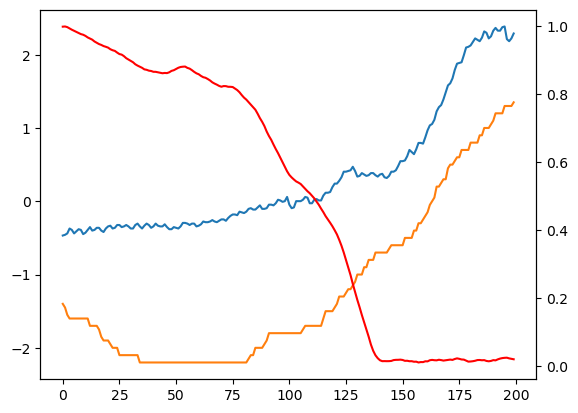

In [884]:
fig, ax1 = plt.subplots()
ax1.plot(targets.values[-200:])
ax1.plot(testData.temperatures.DC_GT301_damped.values[-200:]+25)
ax2 = ax1.twinx()
ax2.plot(testData.flow.TA01_GP101.values[-200:], 'r')

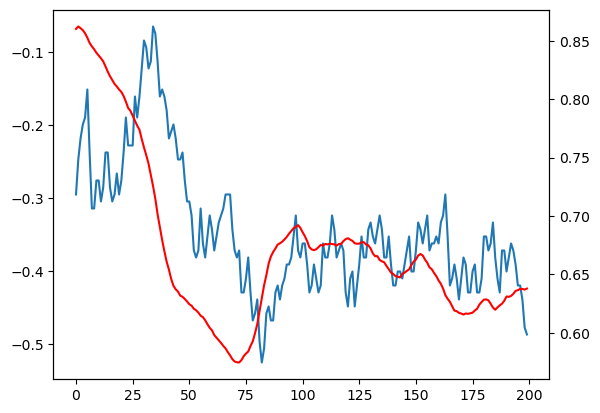

In [885]:
fig, ax1 = plt.subplots()
ax1.plot(targets.values[-1800:-1600])
ax2 = ax1.twinx()
ax2.plot(testData.flow.TA01_GP101.values[-1800:-1600], 'r')
#ax2.plot(testData.flow.TA01_GP101_temp.values[-1800:-1600], 'm')

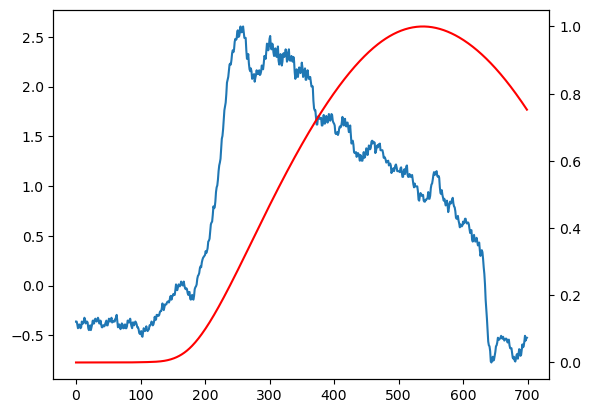

In [886]:
fig, ax1 = plt.subplots()
ax1.plot(targets.values[-1700:-1000])
ax2 = ax1.twinx()
ax2.plot(testData.sun.gsi.values[-1700:-1000], 'r')
# ax2.plot(testData.flow.TA01_GP101.values[-1600:-1200], 'r')
# ax2.plot(testData.flow.TA01_GP101_temp.values[-1600:-1200], 'm')

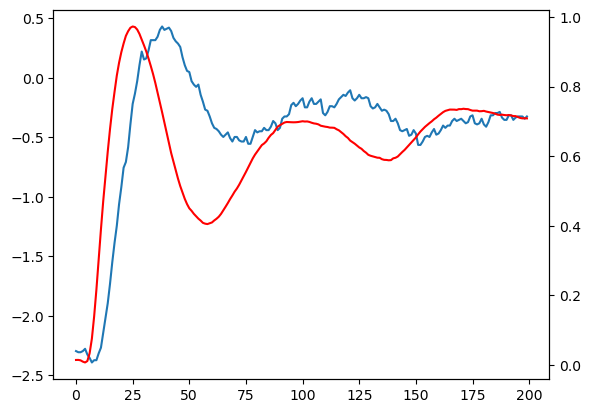

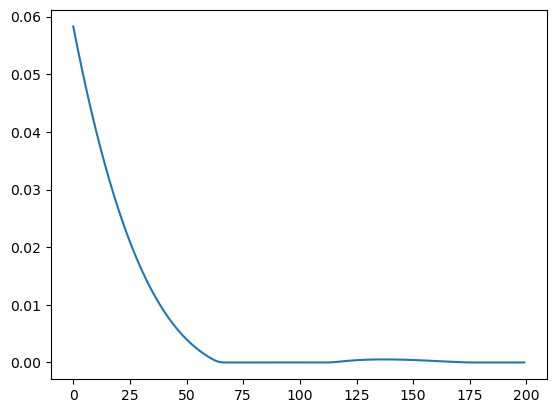

In [887]:
fig, ax1 = plt.subplots()
ax1.plot(targets.values[-800:-600])
ax2 = ax1.twinx()
ax2.plot(testData.flow.TA01_GP101.values[-800:-600], 'r')
#ax2.plot(testData.flow.TA01_GP101_temp.values[-800:-600], 'm')
plt.show()

# plt.plot(testData.time['mod'].values[-800:-600])
plt.plot(testData.sun.gsi.values[-800:-600])

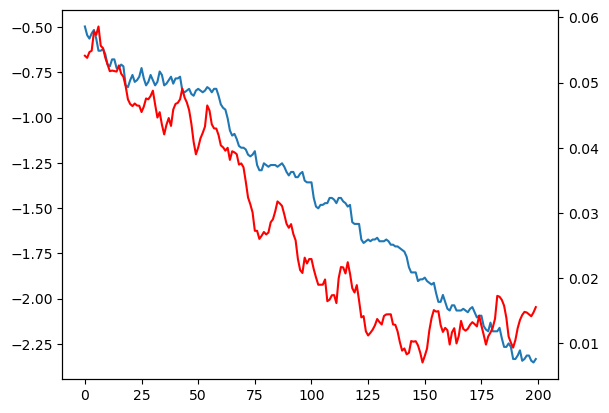

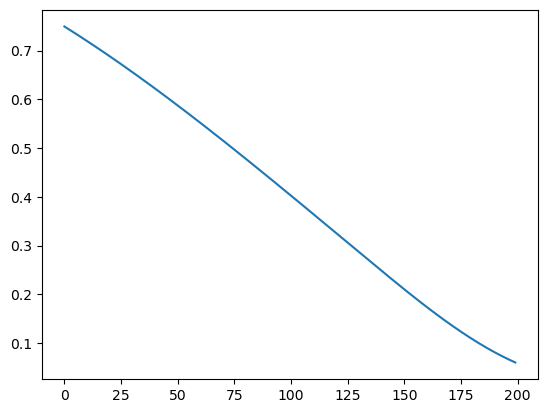

In [888]:
fig, ax1 = plt.subplots()
# ax1.plot(testData.temperatures.TA01_GT10X_GM10X.values[-1000:-800])
ax1.plot(targets.values[-1000:-800])
ax2 = ax1.twinx()
ax2.plot(testData.flow.TA01_GP101.values[-1000:-800], 'r')
#ax2.plot(testData.flow.TA01_GP101_temp.values[-1000:-800], 'm')

plt.show()
# plt.plot(testData.time['mod'].values[-800:-600])
plt.plot(testData.sun.gsi.values[-1000:-800])

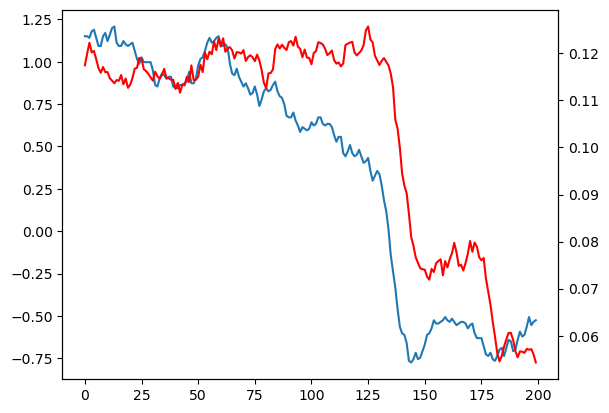

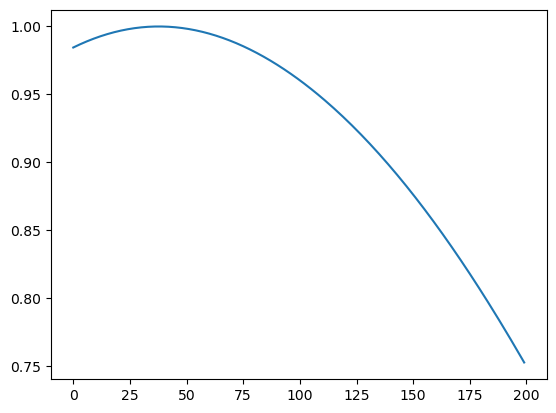

In [889]:
fig, ax1 = plt.subplots()
# ax1.plot(testData.temperatures.TA01_GT10X_GM10X.values[-1200:-1000])
ax1.plot(targets.values[-1200:-1000])
ax2 = ax1.twinx()
ax2.plot(testData.flow.TA01_GP101.values[-1200:-1000], 'r')
#ax2.plot(testData.flow.TA01_GP101_temp.values[-1200:-1000], 'm')

plt.show()
# plt.plot(testData.time['mod'].values[-800:-600])
plt.plot(testData.sun.gsi.values[-1200:-1000])

In [895]:
from sklearn.linear_model import LinearRegression, Ridge

# X = testData[[('flow', 'TA01_GP101'), ('temperatures', 'TA01_GT10X_GM10X')]].values[-1200:-1000]
X = testData[[('flow', 'TA01_GP101')]].values[-1200:-1000]
Y = targets.values[-1200:-1000]

In [896]:
model = Ridge().fit(X, Y)
C = model.coef_

In [897]:
C

array([2.55729587])

In [898]:
test = np.sum(C * X, axis=1)

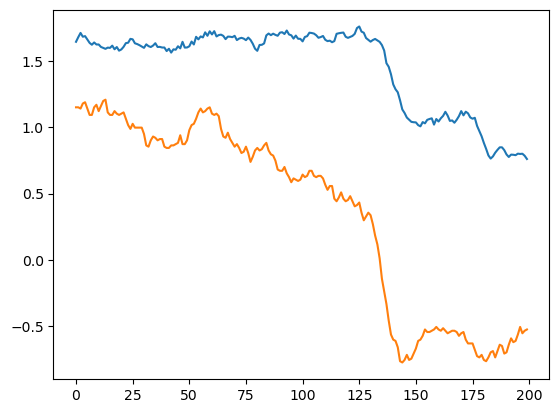

In [905]:
#plt.plot(test)
plt.plot(X*14)
plt.plot(Y)